In [7]:
import gensim
import os
import collections
import smart_open
import random
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [4]:
# Set file names for train and test data
test_data_dir = 'data'
train_file = test_data_dir + os.sep + 'ingredient2vec'

def read_corpus(fname, tokens_only=False):
    with smart_open.smart_open(fname, encoding="iso-8859-1") as f:
        for i, line in enumerate(f):
            if tokens_only:
                yield gensim.utils.simple_preprocess(line)
            else:
                # For training data, add tags
                line_split = line.split(' ')
                ingredient = line_split[0]
                compounds = ' '.join(line_split[1:])
                yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(compounds), [ingredient])
                
train_corpus = list(read_corpus(train_file))
train_corpus[:10]

[TaggedDocument(words=[u'nonanone'], tags=['ruta_chalepensis_oil']),
 TaggedDocument(words=[u'butyl_butyrate'], tags=['passiflora_mollissima']),
 TaggedDocument(words=[u'thymol', u'octanone', u'pentylfuran', u'nerolidol', u'myrcene', u'formyl', u'ene', u'isopulegol', u'salicylaldehyde', u'mentha', u'dien', u'ol', u'octanal', u'methylanisole', u'veratraldehyde'], tags=['mastic_gum_oil']),
 TaggedDocument(words=[u'benzyl_alcohol'], tags=['copaiba']),
 TaggedDocument(words=[u'bornyl_acetate', u'isoamyl_alcohol'], tags=['teucrium_chamaedrys']),
 TaggedDocument(words=[u'menth', u'ene', u'al', u'piperitone', u'formyl', u'ene'], tags=['seed_oil']),
 TaggedDocument(words=[u'taurine'], tags=['octopus']),
 TaggedDocument(words=[u'phenyl', u'propanol'], tags=['storax']),
 TaggedDocument(words=[u'trimethyl', u'cyclohexa', u'dienyl', u'but', u'en', u'one'], tags=['summer_savory']),
 TaggedDocument(words=[u'diacetyl'], tags=['fagroea_racemosa_flower'])]

In [9]:
### Train Model

#dm/m,d50,n5,w5,mc5,s0.001,t3
model = gensim.models.doc2vec.Doc2Vec(size=50, min_count=20, iter=55)
model.build_vocab(train_corpus)
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.iter)

CPU times: user 38.3 s, sys: 2min 1s, total: 2min 39s
Wall time: 8.15 s


TypeError: object of type 'Doc2Vec' has no len()

In [19]:
ranks = []
second_ranks = []
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    rank = [docid for docid, sim in sims].index(train_corpus[doc_id].tags[0])
    ranks.append(rank)
    
    second_ranks.append(sims[1])

In [20]:
collections.Counter(ranks)  # Results vary due to random seeding and very small corpus

Counter({0: 265,
         1: 36,
         2: 28,
         3: 25,
         4: 19,
         5: 21,
         6: 9,
         7: 8,
         8: 8,
         9: 7,
         10: 13,
         11: 9,
         12: 4,
         13: 5,
         14: 1,
         15: 5,
         16: 8,
         17: 13,
         18: 10,
         19: 4,
         20: 4,
         21: 5,
         22: 5,
         23: 5,
         24: 2,
         25: 4,
         26: 5,
         27: 6,
         28: 7,
         29: 12,
         30: 5,
         31: 5,
         32: 4,
         33: 4,
         34: 6,
         35: 4,
         36: 6,
         37: 4,
         38: 2,
         39: 3,
         40: 2,
         41: 7,
         42: 4,
         43: 3,
         44: 6,
         45: 3,
         46: 3,
         47: 5,
         48: 5,
         49: 3,
         50: 3,
         51: 3,
         52: 3,
         53: 4,
         54: 7,
         55: 9,
         56: 2,
         57: 6,
         58: 5,
         60: 2,
         61: 3,
         62: 5,
       

In [30]:
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(train_corpus))

# Compare and print the most/median/least similar documents from the train corpus
print('Train Document ({}, {}): [{}]\n'.format(doc_id, train_corpus[doc_id].tags[0], ' '.join(train_corpus[doc_id].words)))

inferred_vector = model.infer_vector(train_corpus[doc_id].words)
sims = model.docvecs.most_similar([inferred_vector], topn=10)
for sim in sims:
    print sim

Train Document (106, bael): [cis]

('sauerkraut', 0.5108747482299805)
('berry', 0.3559003174304962)
('pistachio', 0.35406920313835144)
('roasted_nut', 0.3413326144218445)
('houttuynia_cordata_oil', 0.32550713419914246)
('olive_oil', 0.3111167550086975)
('vanilla_oil', 0.3064221739768982)
('blueberry', 0.3038571774959564)
('onion_juice', 0.3033254146575928)
('prune', 0.29863062500953674)


In [33]:
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(train_corpus))
inferred_vector = model.infer_vector(train_corpus[doc_id].words)
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

# Compare and print the most/median/least similar documents from the train corpus
print('Train Document ({}, {}): [{}]\n'.format(doc_id, train_corpus[doc_id].tags[0], ' '.join(train_corpus[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print label, sims[index]
    #print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

Train Document (216, coconut): [undecalactone hexen ol lauric_acid hexalactone octadeca methyl_esters decalactone heptanone octanol pentanol ethyl_myristate cresol oleic_acid undecanol propionic_acid palmitic_acid diethyl methylpyrazine nonanoic_acid ethyl_octanoate heptanoic_acid nonanol heptanol octanal hexyl_alcohol octanoic_acid pentadecanone methyl pyrrolyl_ketone octanol hexanoic_acid ethyl_laurate decanal pyridine nonanone methyl_laurate cresol tridecanone ethyl_acetate valeraldehyde myristic_acid octalactone undecanone dodecalactone benzothiazole valeric_acid nonanal delta]

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dm/m,d50,n5,w5,mc20,s0.001,t3):

MOST ('roasted_coconut', 0.7823314070701599)
MEDIAN ('pennyroyal', 0.4226566553115845)
LEAST ('onion_juice', -0.39978963136672974)


In [171]:
print train_corpus[0].tags

['ruta_chalepensis_oil']


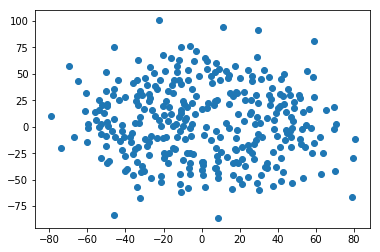

In [29]:
# TSNE

# word-level
X = model[model.wv.vocab]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()

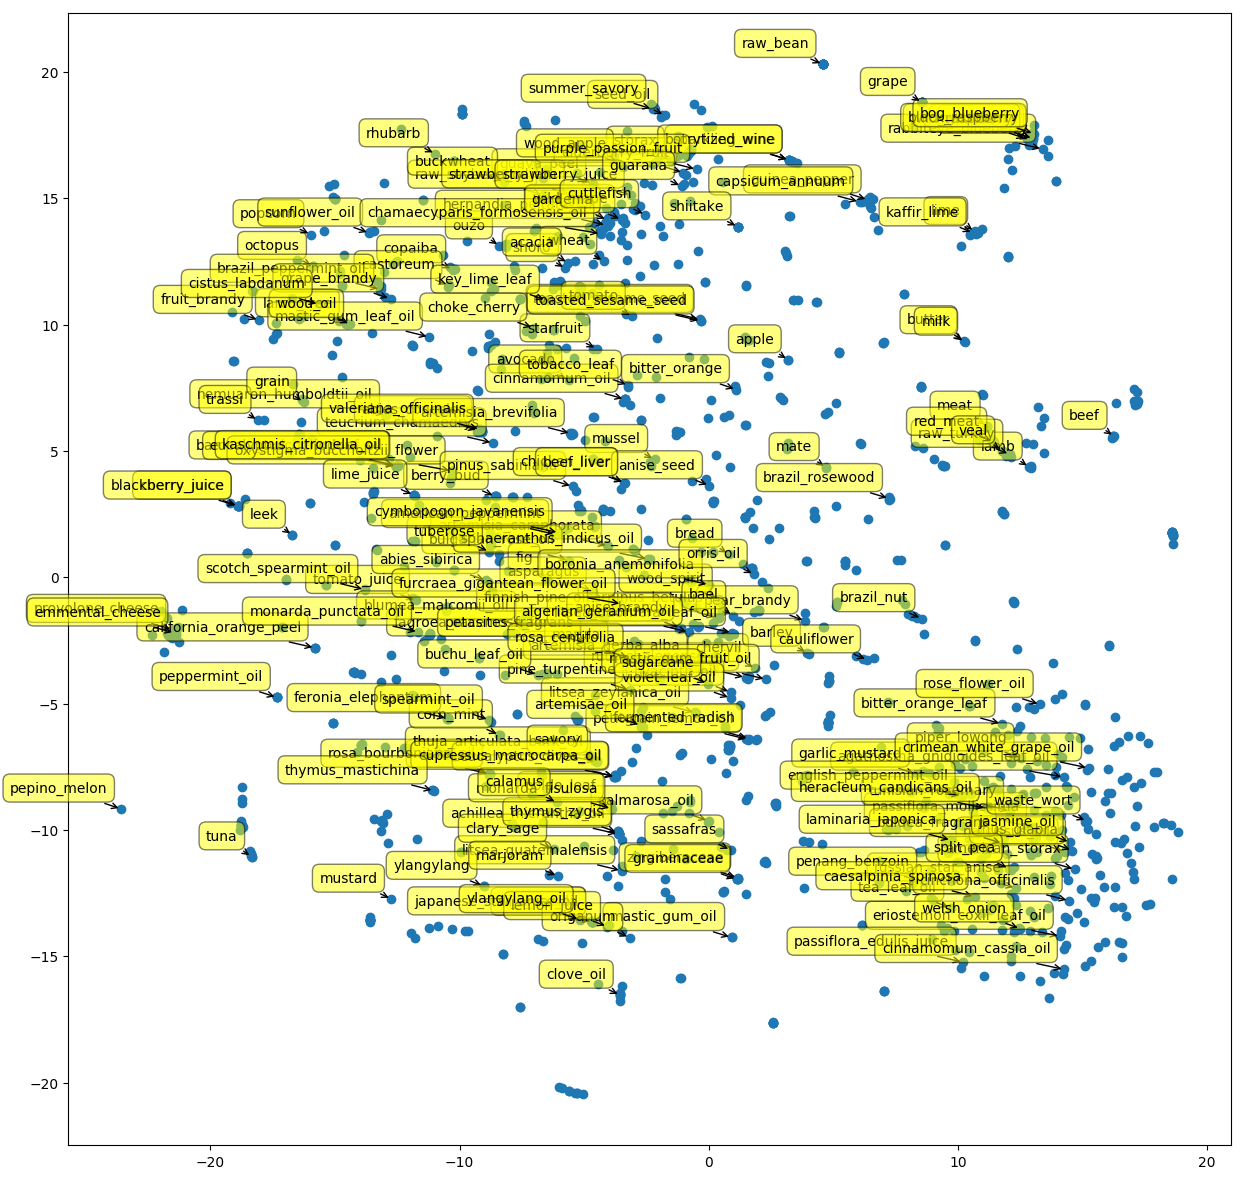

In [73]:
# ingredient-level
X = model.docvecs

labels = []
for i in range(0, len(model.docvecs)):
    labels.append(model.docvecs.index_to_doctag(i))
    
    
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)


#define plot size in inches (width, height) & resolution(DPI)
fig = plt.figure(figsize=(15, 15), dpi=100)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])

for label, x, y in zip(labels[:200], X_tsne[:, 0][:200], X_tsne[:, 1][:200]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-10, 10),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
    )
plt.show()